# Energetics Theory
In this notebook a single run is loaded, and the predictions of theory for integrated dissipation are tested.


In [453]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.special as special
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [470]:
#%% Pick the filename and path
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/snapshots_0p10.h5' #0.1 slope
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05_LONG.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-7_0p42/snapshots/snapshots_5e-7_0p42.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p0225/snapshots/snapshots_1e-5_0p0225.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LONG.h5' #Ruan case F
# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_Q1D.h5' #Ruan case F

# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LONG.h5' #Ruan case F
# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LOWV.h5' #Ruan case F

# filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005.h5' #Ruan case A
# filename =  '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01.h5'
# filename =  '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p1/snapshots/snapshots_1e-6_0p1.h5'
filename =  '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-6_0p02/snapshots/snapshots_5e-6_0p02.h5'

# filename =  '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/downslope/downslope_s2.h5' # oscillating current


visc = 5e-5
visc = 1e-4

f = h5py.File(filename, 'r')

# Get the data
data = list(f['tasks'])

# Basic parameters
N = f['tasks']['N'][0,0,0] #Interior stratification (background)
tht = f['tasks']['tht'][0,0,0] # Slope angle


# Load variables in physical space
u = f['tasks']['u'] # Cross-slope direction
v = f['tasks']['v'] # Along-slope direction
w = f['tasks']['w'] # Slope-normal direction
b = f['tasks']['b'] # Perturbation buoyancy

qa = f['tasks']['PVa']
q = f['tasks']['PV']
wq = f['tasks']['wq']
# Energy terms XXX - Need to go clean these up in Dedalus
gsp = f['tasks']['GSP']
gspr = f['tasks']['GSProtated']
vspu = f['tasks']['VSPu']
vspv = f['tasks']['VSPv']
vsp = vspu[:,:,:]+vspv[:,:,:]
lspu = f['tasks']['LSPu']
lspv = f['tasks']['LSPv']
lsp = lspu[:,:,:] + lspv[:,:,:]
diss = f['tasks']['Diss']
dissb = f['tasks']['DISSBPARTIAL']

vbf = f['tasks']['VBF']
# vbfsg= f['tasks']['VBFsg']
vbfr = f['tasks']['VBFr']
WPBP = f['tasks']['VBFrotated']
hbfr = f['tasks']['HBFrotated']
hbfr = hbfr*np.sin(tht)
#vbfrot = f['tasks']['VBFrotated']
sp = f['tasks']['SP']
EKE = f['tasks']['EKE']

# SPECTRAL QUANTITIES
ws = f['tasks']['wcs']
bs = f['tasks']['bs']
vs = f['tasks']['vcs']


# Domain parameters
x = u.dims[1][0][:]
z = u.dims[2][0][:]
time = u.dims[0][0][:]
kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction

In [471]:
# Calculated quantities
# XXX- Go through and check this all carefully
va = np.mean(v, axis=1)

qm = np.mean(q, axis=1) 
bm = np.mean(b, axis=1)


um = np.mean(u, axis=1)
vm = np.mean(v, axis=1)
up = u - um[:,np.newaxis,:]
vp = v - vm[:,np.newaxis,:]

uz = np.gradient(um, axis=-1)/np.gradient(z)
vz = np.gradient(vm, axis=-1)/np.gradient(z) 
wz = np.gradient(np.mean(w, axis=1), axis=-1)/np.gradient(z)
zm = z-z[-1]


#zetaprimebprime = np.mean((bf - np.mean(bf,axis=1))*(np.gradient(v, axis=1)/np.gradient(x)), axis=1)
#uz = np.gradient(u, axis=-1)/np.gradient(z)
#vz = np.gradient(v, axis=-1)/np.gradient(z)

EKEt = np.gradient(EKE[:,0,:], axis=0)/np.gradient(time[:,np.newaxis], axis=0)

MKE = 0.5*(um**2 + (vm)**2)
MKEt = np.gradient(MKE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

MAPE = 0.5*bm**2/N**2
MAPEt = np.gradient(MAPE, axis=0)/np.gradient(time[:,np.newaxis], axis=0)

EPE = 0.5*np.mean((b - bm[:,np.newaxis,:])**2, axis=1)/N**2
# estimate bottom stress
tauy = -1035*visc*vz[:,0] #Note that 1e-4 is the viscosity for the DNS
taux = -1035*visc*uz[:,0] #Note that 1e-4 is the viscosity for the DNS
S2 = N**2 *tht**2/1e-8

Bek = tauy/(1030*1e-4*(1+S2))*N**2*tht

DISSSI = 1/(1+S2)*(WPBP[:,:,:] - gspr[:,:,:])

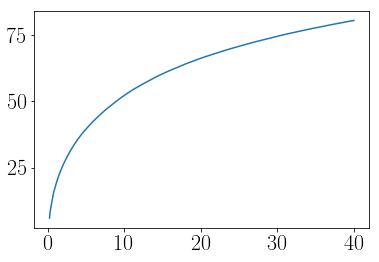

In [472]:
# Calculate H
nt = Bek.shape[0]

toff = 12*2 # Starting timestep
Ho = 14 # Pick a starting depth (not necessarily starting at t=0, H=0)

toff = 12
Ho = 5
Ent = 1.0 # Entrainment factor...
H2 = np.zeros((nt, )) 
for i in range(toff, nt):
    H2[i] = H2[i-1]+(2*Ent*-(1+S2)*Bek[i]/(N**2))*(time[i]-time[i-1])
    
H = np.sqrt(Ho**2 + H2)
H[0:toff] = np.nan
plt.plot(time/86400, H)

## Begin Energy Comparison

Notice that the equation for the PV=0 layer depth gives,
\begin{equation}
\frac{\partial H^2}{\partial t} = - \frac{\tau^y\theta}{\rho}
\end{equation}
This can then be rearranged to give an equation for the stress in terms of the BBL height. 

Noting that the depth integrated SI dissipation is,
\begin{equation}
\int_0^H \epsilon \approx \frac{H}{2}EBF_s
\end{equation}
allows the depth integrated dissipation to be written as,

\begin{equation}
\int_0^H \epsilon \approx \frac{1}{6}\frac{\partial H^3}{\partial t}\frac{N^2}{1+S^2_\infty}
\end{equation}

This can then be integrated in time until the arrested Ekman depth is achieved, $H_a = V_\infty f (1+S^2_\infty)/N^2\theta$. Giving the total dissipation during arrest as,

\begin{equation}
\int_0^\infty \int_0^H \epsilon\;dz dt \approx \frac{1}{6}H_a^3\frac{N^2}{1+S^2_\infty}
\end{equation}

\begin{equation}
\int_0^\infty \int_0^H \epsilon\;dz dt \approx \frac{1}{6}\frac{V_i^3f^3(1+S^2_\infty)^3}{N^6\theta^3}\frac{N^2}{1+S^2_\infty}
\end{equation}

\begin{equation}
\int_0^\infty \int_0^H \epsilon\;dz dt \approx \frac{1}{6}\frac{V_i^3(1+S^2_\infty)^2}{N_\infty S_\infty^3}
\end{equation}

In [473]:
Tscale = (1+S2)**2/(6*N*S2**(3/2))
cd = 2e-3
TscaleBL = (1+S2)**2/(2*N*S2**(3/2)*cd) # BRINK and LENTZ formulation
Vi = 0.1
TscaleBL = (1+S2)**2*Vi**2/(2*N*S2**(3/2)*np.max(np.abs(tauy)/1035))
TscaleBL/86400

27.135784346543627

In [488]:
# Integrate vertically and in time

# Dissipation of EKE
DISSi = integrate.trapz(diss[:,0,:], axis=-1, x=z)
DISSti = integrate.cumtrapz(DISSi, x=time, initial=0)
DISSti.shape

DISSSIi = integrate.trapz(DISSSI[:,0,:], axis=-1, x=z)
DISSSIti = integrate.cumtrapz(DISSSIi, x=time, initial=0)

# Dissipation of MKE
vgzm = -np.gradient(bm, axis=-1)/np.gradient(z)*tht/1e-4
MDISS = -1e-4*(uz**2 + vz**2 )
MDISSi = integrate.trapz(MDISS, axis=-1, x=z)
MDISSti = integrate.cumtrapz(MDISSi, x=time, initial=0)

# Dissipation of EPE
DISSBi = integrate.trapz(dissb[:,0,:], axis=-1, x=z)
DISSBti = integrate.cumtrapz(DISSBi, x=time, initial=0)
# Dissipation of MAPE
bz = np.gradient(bm, axis=-1)/np.gradient(z)
MDISSB = -1e-4*((bz)*(bz))/N**2
MDISSBi = integrate.trapz(MDISSB, axis=-1, x=z)
MDISSBti = integrate.cumtrapz(MDISSBi, x=time, initial=0)

# Rate of change of EKE and MKE
dEKEi = integrate.trapz(EKEt, axis=-1, x=z)
dEKEti= integrate.cumtrapz(dEKEi, x=time, initial=0)
dMKEi = integrate.trapz(MKEt, axis=-1, x=z)
dMKEti= integrate.cumtrapz(dMKEi, x=time, initial=0)

# Rate of change of MAPE
dMAPEi = integrate.trapz(MAPEt, axis=-1, x=z)
dMAPEti = integrate.cumtrapz(dMAPEi, x=time, initial = 0)
dEPEti = integrate.trapz(EPE, axis=-1, x=z)

In [459]:
bz[:,-5]+0*N**2

array([-6.10298469e-08,  2.38691686e-11,  4.33940102e-12, ...,
        8.87978082e-12,  8.88223843e-12,  8.88353247e-12])

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


Diss/Drag ratio: 0.35
Q ratio: 0.2
Q ratio no SI: 0.4


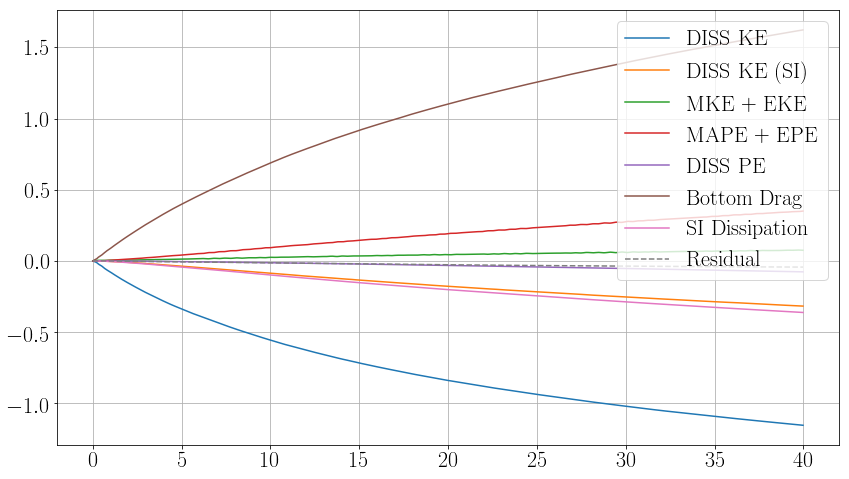

In [475]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.figure(figsize=(14,8))
#plt.plot(time/86400, -DISSti, label='Dissipation')
#plt.plot(time/86400, MDISSti, label='Mean Dissipation')

plt.plot(time/86400, MDISSti+DISSti, label='DISS KE')
plt.plot(time/86400, -DISSSIti, label='DISS KE (SI)')

plt.plot(time/86400, dMKEti + dEKEti, label='MKE + EKE')
plt.plot(time/86400, dMAPEti+dEPEti, label='MAPE + EPE')
plt.plot(time/86400,DISSBti + MDISSBti, label='DISS PE')

BDRAG = integrate.cumtrapz(-0.1*tauy/1035, x=time, initial=0)
plt.plot(time/86400, BDRAG, label='Bottom Drag')
plt.plot(time/86400, -1/6*H**3*N**2/(1+N**2*tht**2/1e-8), label='SI Dissipation')
residual = dMAPEti + dEKEti + dMKEti +dEPEti - BDRAG -DISSti - MDISSti - 0*DISSBti - 0*MDISSBti
plt.plot(time/86400, residual, label='Residual', linestyle='--')
plt.grid()
plt.legend()

#Q efficiency is bottom drag minus total dissipation over total dissipation
ts = np.argmin(np.abs(time/86400 - 15))

#(EKE_t + MKE_t) + (EPE_t + MPE_t) = DRAG - DISS
print('Diss/Drag ratio: %1.2f'%((-DISSti)/BDRAG)[ts])
#print('Q ratio: %1.1f'%((BDRAG - (dMKEti + MDISSti-DISSti))/( MDISSti-DISSti))[ts])
print('Q ratio: %1.1f'%(dMAPEti/( -MDISSti-DISSti))[ts])

print('Q ratio no SI: %1.1f'%(dMAPEti/(-MDISSti))[ts])

# Predict ratio of SI dissipation to bottom drag
Ratio of bottom drag on interior flow to SI dissipation

Bottom drag goes as $V_i \tau^y$. SI dissipation goes as $\frac{1}{6}\frac{\partial H^3}{\partial t}\frac{N^2}{1+S^2_\infty}$. 

Using the rate of change of H, the bottom drag can be written as ,
\begin{equation}
DRAG = V_i \frac{f}{2\theta}\frac{\partial H^2}{\partial t}.
\end{equation}

So the time integrated drag is,
\begin{equation}
\int_o^T DRAG = V_i \frac{f}{2\theta}H^2(T).
\end{equation}
and the time integrated SI dissipation is,
\begin{equation}
DISS_{SI} = \frac{1}{6}H^3(T)\frac{N^2}{1+S^2_\infty}
\end{equation}
Hence the ratio of the two is,
\begin{equation}
\frac{DISS_{SI}}{DRAG} = \frac{1}{3}\frac{H(T) N^2 \theta}{V_i f(1+S^2_\infty)}
\end{equation}
Note that this is $(1/3)V^g/V_i$, such that if $T=T_E$ the ratio is $1/3$.

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


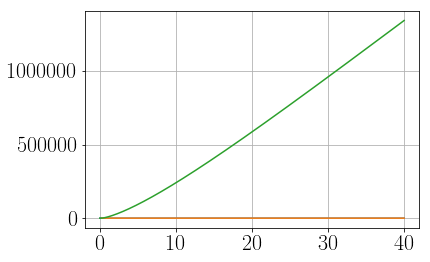

In [461]:
plt.plot(time/86400, (-DISSti)/BDRAG)
plt.plot(time/86400, 1/3*H*N**2*tht/(0.1*1e-4*(1+S2)))
Htemp = H
Htemp[np.isnan(H)] = 0
plt.plot(time/86400, 1/2*integrate.cumtrapz(Htemp, x=time, initial=0)*N**2*tht/(0.1*1e-4*(1+S2)))

plt.grid()

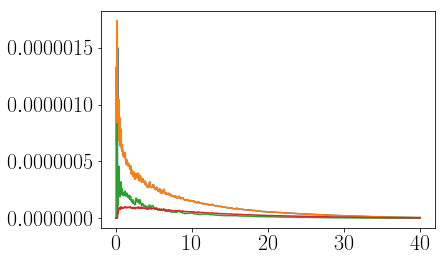

In [462]:
plt.plot(time/86400, 0.1*1e-4/(2*tht)*np.gradient(H**2)/np.gradient(time)) #scaling for bottom drag
plt.plot(time/86400, -0.1*tauy/1035)# actual bottom drag
plt.plot(time/86400, -DISSi) #actual diss
plt.plot(time/86400, 1/6*N**2/(1+S2)*np.gradient(H**3)/np.gradient(time)) #scaling for diss


ValueError: operands could not be broadcast together with shapes (2160,) (1920,) 

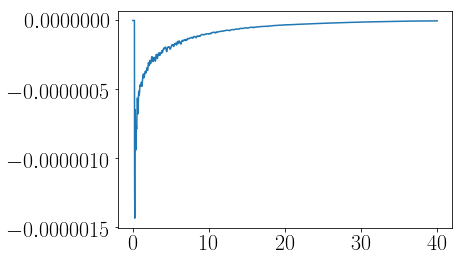

In [463]:
#plt.plot(time/86400, 0.1*1e-4/(2*tht)*np.gradient(H**2)/np.gradient(time) - 1/6*N**2/(1+S2)*np.gradient(H**3)/np.gradient(time)) #scaling for bottom drag
plt.plot(time/86400, -0.5*np.gradient(H**2)/np.gradient(time)*0.1*1e-4/(tht)*(1 - 1/2*N**2*tht/(0.1*1e-4*(1+S2))*H)) #scaling for bottom drag
#plt.plot(time/86400, 0.1*tauy/1035*(1 - 3/2*N**2*tht/(0.1*1e-4*(1+S2))*H)) #scaling for bottom drag

plt.plot(time/86400, Vgt[:,0]*tauy/1035 + DISSi)# actual bottom drag
plt.plot(time/86400, DISSi) #actual diss
#plt.plot(time/86400, 1/6*N**2/(1+S2)*np.gradient(H**3)/np.gradient(time)) #scaling for diss
plt.grid()

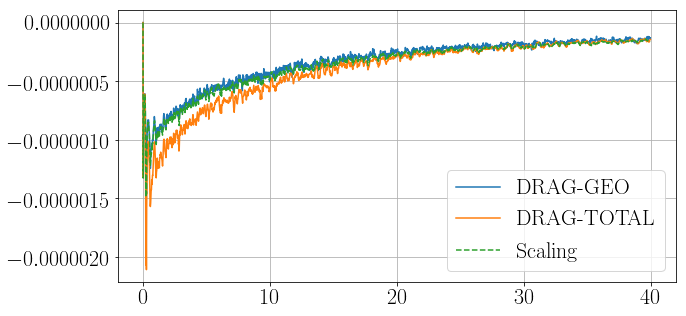

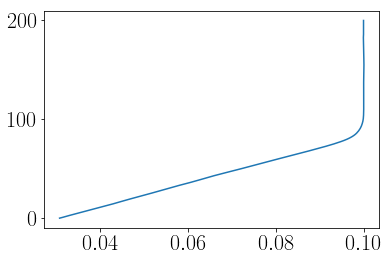

In [489]:
#Compare SI dissipation to bottom drag on geo flow
Vgt = integrate.cumtrapz(-bz*tht/1e-4, axis=-1, x=z, initial = 0)
Vgt = Vgt - Vgt[:,-1][:,np.newaxis] + 0.1

plt.figure(figsize=(10, 5))
#plt.plot(time/86400, DISSSIi/((Vgt[:,0])*tauy/1035), label='DISS/DRAG') #Diss over drag actual
#plt.plot(time/86400, DISSi/((0.1*tauy/1035))) #Diss over drag actual

#plt.plot(time/86400, H*N**2*tht/(2*0.1*1e-4*(1+S2)), label='Scaling') #Diss over drag scaling
#plt.plot(time/86400, H*N**2*tht/(3*0.1*1e-4*(1+S2))) #Diss over drag scaling
plt.plot(time/86400, Vgt[:,0]*tauy/1035 - DISSSIi, label='DRAG-GEO')
plt.plot(time/86400, Vgt[:,0]*tauy/1035 + DISSi, label='DRAG-TOTAL')

DeltaVg = 0.1-Vgt[:,0]
plt.plot(time/86400, tauy/1035*(0.1 - 0.5*DeltaVg), linestyle='--', label='Scaling')
#plt.plot(time/86400, -Vgt[:,0]*tauy/1035)
#plt.plot(time/86400, -DISSi)
#plt.plot(time/86400, 1/6*N**2/(1+S2)*np.gradient(H**3)/np.gradient(time)) #scaling for diss

#plt.ylim(0, 3e-7)
plt.grid()
plt.legend()

plt.figure()
plt.plot(Vgt[-100,:], z)

In [477]:
S2

0.19999999999999993

In [ ]:
plt.plot(time/86400, -H*Bek)
plt.plot(time/86400, N**2*np.gradient(H**3)/np.gradient(time)/(1+S2)/3)

In [ ]:
plt.plot(time/86400, tauy/1035)
plt.plot(time/86400, 1e-4*Bek*(1+S2)/(N**2*tht))

## Total integrated $\Delta MAPE$

Note that the change in MAPE is given by $b^2/(2N^2_\infty)$.
Using the arrested Ekman scaling, the momentum balance at arrest will be $-fV_\infty = b\theta$, hence at arrest, $b = -fV_\infty/\theta$. 

Assuming the buoyancy anomaly decays linearly through the boundary layer this implies $b \propto (1 - z/H)$, hence

\begin{equation}
\Delta MAPE = \int_0^H \frac{b^2}{2 N^2_\infty} = \frac{f^2 V^2_\infty H_a}{6N^2\theta^2}= \frac{ V^2_\infty H_a}{6S^2_\infty}.
\end{equation}

It was shown above that the time and depth integrated SI dissipation at the time of arrest is given by,
\begin{equation}
\int_0^\infty \int_0^H \epsilon\;dz dt \approx \frac{1}{6}H_a^3\frac{N^2_\infty}{1+S^2_\infty}
\end{equation}

The ratio fo these two is therefore,

\begin{equation}
\frac{\Delta MAPE}{DISS} \approx \frac{V_\infty^2 (1+S^2_\infty)}{S_\infty^2H^2N^2_\infty}
\end{equation}

Ratio of MAPE/DISS_SI numerical = 1.1035765248422837
Ratio of MAPE/DISS numerical = 0.6266320417090273
Ratio expected from scaling = 0.8333333333333334


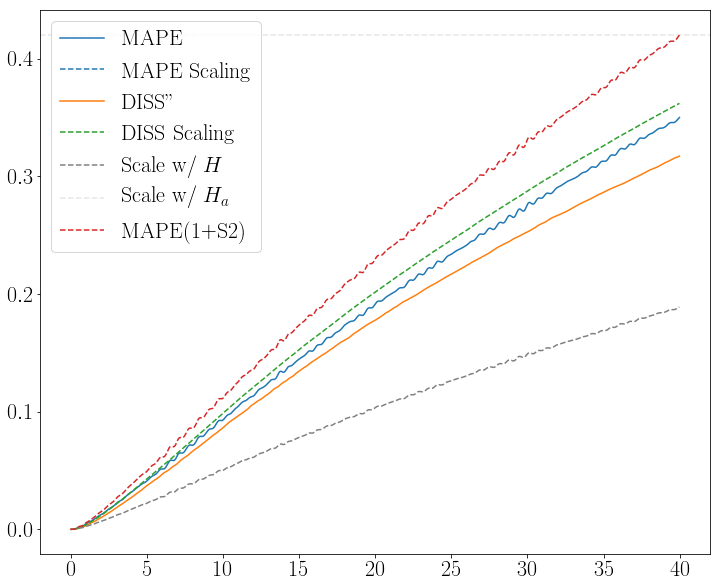

In [487]:
# Change in MAPE versus Integrated dissipation
offsettime = 0*48*5

MAPEi = integrate.trapz(MAPE, axis=-1, x=z)
plt.figure(figsize=(12,10))
plt.plot(time/86400, MAPEi-MAPEi[offsettime], label='MAPE')
plt.axhline(0.1**2*(H[-1]-H[offsettime])/(6*S2), linestyle='--', label='MAPE Scaling')
plt.plot(time/86400, DISSSIti, label='DISS"')
#plt.axhline(1/6*0.1**3*(1+S2)**2/(N*S2**(3/2)))
plt.plot(time/86400, 1/6*(H)**3*N**2/(1+S2), linestyle='--', label='DISS Scaling')
Ha = 0.1*1e-4*(1+S2)/(N**2*tht)
plt.plot(time/86400, MAPEi*S2*H[-1]**2*N**2/(0.1**2*(1+S2)), linestyle='--', label='Scale w/ $H$', color='0.5')
plt.axhline( (MAPEi[-1]-MAPEi[offsettime])*S2*Ha**2*N**2/(0.1**2*(1+S2)), linestyle='--', label='Scale w/ $H_a$', color='0.9')

plt.plot(time/86400, (MAPEi-MAPEi[offsettime])*(1+S2), linestyle='--', label  =  'MAPE(1+S2)')

plt.legend()

print(f'Ratio of MAPE/DISS_SI numerical = {MAPEi[-1]/DISSSIti[-1]}')
print(f'Ratio of MAPE/DISS numerical = {-MAPEi[-1]/DISSti[-1]}')
print(f'Ratio expected from scaling = {1/(1+S2)}')
#print(f'Ratio from num and scaling = {0.1**2*(1+S2)/(S2*Ha**2*N**2)}')

In [ ]:
0.1**2*(1+S2)/(S2*H[-1]**2*N**2)

In [ ]:
S2

In [482]:
H[-1]/(0.1*1e-4*(1+S2)/(N**2*tht))

0.6707728009225786